In this post, we will explore the Gaussian Process in the context of regression. This is a topic I meant to study for a long time, yet was never able to due to the seemingly intimidating mathematics involved. However, after consulting some extremely well-curated resources on this topic, such as [Kilian's lecture notes](https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote15.html) and [UBC lecture videos by Nando de Freitas](https://www.youtube.com/watch?v=MfHKW5z-OOA&list=PLE6Wd9FR--EdyJ5lbFl8UuGjecvVw66F6&index=9), I think I'm finally starting to understand what GP is. I highly recommend that you check out these resources, as they are both very beginner friendly and build up each concept from the basics. With that out of the way, let's get started.

# Why GPs?

Let's begin by considering the classic setup of a regression problem. The goal of regression is to predict some values given a set of observations, otherwise referred to as a training set. There are of course many variants of the regression problem. For instance, in a previous post we took a look at [Bayesian linear regression](https://jaketae.github.io/study/bayesian-regression/), where instead of a single point estimate, we tried to derive a distribution of the predicted data at a given test point. 

Gaussian Processes (GPs) are similar to Bayesian linear regression in that the final result is a distribution which we can sample from. The biggest point of difference between GP and Bayesian regression, however, is that GP is a fundamentally non-parametric approach, whereas the latter is a parametric one. I think this is the most fascinating part about GPs---as we will see later on, GPs do not require us to specify any function or model to fit the data. Instead, all we need to do is to identify the mean and covariance of a multivariate Gaussian that defines the posterior of the GP. 

# GP Regression

All of this sounds too good be true---how can a single multivariate Gaussian distribution be enough for what could potentially be a high-dimensional, complicated regression problem? Let's discuss some mathematical ideas that enable GP to be so powerful.

## Gaussian Distributions

Gaussians are essentially a black hole of distributions: once a Gaussian, always a Gaussian. For example, we know from a previous post on [Gibbs sampling](https://jaketae.github.io/study/gibbs-sampling/#conditionals-of-multivariate-gaussians) that the conditional of a multivariate Gaussian is also Gaussian.

$$
\mathbf{x_2 \vert x_1} \sim \mathcal{N} \left(\mu_2 + \Sigma_{12}^\top \Sigma_{11}^{-1} (\mathbf{x_1} - \mu_1), \Sigma_{22} - \Sigma_{12}^\top \Sigma_{11}^{-1} \Sigma_{12} \right) \tag{1}
$$

given the setup that 

$$
\mathbf{x} = \begin{bmatrix} \mathbf{x_1} \\ \mathbf{x_2} \end{bmatrix} \tag{2}
$$

and 

$$
\Sigma = \begin{bmatrix} \Sigma_{11} & \Sigma_{12} \\ \Sigma_{21} & \Sigma_{22} \end{bmatrix} \tag{3}
$$

And of course, the marginal of a multivariate Gaussian also produces another Gaussian. 

$$
\mathbf{x_1} \sim \mathcal{N}(\mu_1, \Sigma_{11}) \\
\mathbf{x_2} \sim \mathcal{N}(\mu_2, \Sigma_{22}) \tag{4}
$$

This marginalization property can be understood both intuitively by thinking about the implications of viewing the mean and covariance as vectors and matrices, or by taking a direct integral:

$$
p(\mathbf{x_1}) = \int_\mathbf{x_2} p(\mathbf{x_1}, \mathbf{x_2}; \mu, \Sigma) \, d \mathbf{x_2} \\
p(\mathbf{x_2}) = \int_\mathbf{x_1} p(\mathbf{x_1}, \mathbf{x_2}; \mu, \Sigma) \, d \mathbf{x_2} \\ \tag{5}
$$

Lastly and most importantly, we also saw in the post on Bayesian linear regression that the product of two Gaussians is also Gaussian. Like this, a distribution that is Gaussian most likely stays Gaussian, withstanding such operations as marginalization, multiplication, or conditioning. This is a powerful property that we can use to motivate the "Gaussian-ness" behind GP. 

## Model Marginalization

As stated earlier, GP is non-parametric. Simply put, this means that we don't have to consider things like the typical $\theta$ in the context of linear regression. Normally, we would start off with something like 

$$
\hat{y} = \theta_1 x_1 + \theta_2 x_2 + \cdots + \theta_n x_n 
$$

This is sometimes also written in terms of a weight vector $w$ or a function $f$. Here, we also have some Gaussian noise, denoted by $\epsilon$:

$$
\begin{align}
\hat{y} 
&= w^\top x + \epsilon \\
&= f(x) + \epsilon
\end{align} \tag{6}
$$

However, since GPs are non-parametric, we do not have to specify anything about the model. How do we remove this consideration? The short answer is that we marginalize out the model from the integral. Let $f$ denote the model, $X$ the data, $y$ the predictions.

$$
\begin{align}
p(y \vert X) 
&= \int_f p(y, f \vert X) \, df \\
&= \int_f p(y \vert f, X) \, p (f \vert X) \, df \\
\end{align} \tag{7}
$$

Normally, an integral like the one above would be intractable without a solution in closed form. Hence, we would have to rely on random sampling methods such as MCMC. However, in this case, we do have a closed form solution, and we know what it looks like: a Gaussian! This means that we uniquely identify the final posterior distribution through GP regression---all we need is the mean and covariance.

## Kernel

Let's start with the easy one first: the mean. The mean is a trivial parameter because we can always normalize the mean to zero by subtracting the mean from the data. Therefore, for simplicity purposes, we assume a zero mean throughout this post. 

The interesting part lies in the covariance. Recall that the covariance matrix is defined as follows:

$$
K_{i, j} = \text{cov}(x_i, x_j) \tag{8}
$$

Roughly speaking, covariance tells us how correlated two entries of the random vector are. This is where I think GPs get really interesting: the key point of GP is to realize that we want to model some smooth function that best fits our data. What does this "smootheness" mean in terms of covariance? The answer is that $x$ values that are close to each other must be highly correlated, whereas those that are far apart would have low covariance. In other words, knowing the value of $f(1)$ tells us a lot about the valule of $f(1.1)$, whereas it tells us very little about the valule of $f(10)$. In short, the closer the values, the higher the covariance. So at the end of the day, all there is to GP regression is to construct this covariance matrix using some distrance function. 

In GPs, these covariance matrices are referred to as kernels. Kernels can be understood as some sort of prior that we impose upon the regression problem. The idea of smoothness noted earlier is one such example of a prior. But it is a general prior that makes a lot of sense, since we normally don't want stepwise or non-differential functions as the result of regression. But there are hundreds and thousands of kernels out there that each suit different purposes. For the sake of simplicity, however, we will only take a look at one such kernel that relates to smoothness: the squared exponential kernel, often referred to as the RBF kernel.

The distance function of the squared exponential kernel looks as follows:

$$
k(x_i, x_j) = e^{ - \left\lVert x_i - x_j \right\rVert^2} \tag{9}
$$

We can apply distortions to the RBF function by adding things like coefficients, but for simplicity sake we omit them here.

The key takeaway is that the RBF kernel function functions as a distance metric between two points. As an extreme exmaple, let's consider the case when $x_i = x_j$, the diagonal entries of the covariance matrix, which is effectively the variance along those components. Then, 

$$
\begin{align}
k(x_i, x_j) 
&= k(x_i, x_i) \\
&= e^{ - \left\lVert x_i - x_i \right\rVert^2} \\
&= 1
\end{align} \tag{10}
$$

Conversely, when $x_i$ and $x_j$ are extremely different points,

$$
\begin{align}
k(x_i, x_j) 
&= e^{ - \left\lVert x_i - x_i \right\rVert^2} \\
&= \lim_{m \to \infty}e^{- m^2} \\
&= 0
\end{align} \tag{11}
$$

We can thus deduce that the distance function returns a value between 0 and 1 that indicates the similarity or closeness between two points. This is exactly the sort of behavior we want for the covariance matrix. 

In short, the multivariate Gaussian that we will be using for GP regression can simply be summarized as 

$$
p(f \vert X) = \mathcal{N}(0, K) \tag{12}
$$

where covariance $K$ denotes the kernel matrix.

## GP with Noise

In the RBF kernel function above, we were assuming a function without any noise, namely that $y = f(x)$. However, once we add in Gaussian noise as we saw above with $y = f(x) + \epsilon$ where $\epsilon \sim \mathcal{N}(0, \sigma^2)$, then we need to make adjustments to the kerne to account for added variations. 

With some thinking, we can persuade ourselves that the only modification that is needed pertains to the diagonal entries of the covariance matrix. This is because $\epsilon$ only affects variance that exists within the univariate Gaussian for each point on the $x$-axis without affecting the non-diagonal entries, which otherwise pertain to covariance between two points. In other words, the new kernel matrix now becomes

$$
K' = K + \sigma^2 I \tag{13}
$$

This can be seen as a minor correction to the kernel matrix to account for added Gaussian noise.

## Cholesky Decomposition

Before we jump straight into code implementation, it's necessary to discuss the Cholesky decomposition to get some technicality out of the way. 

The Cholesky decomposition is a specialization of the LDU decomposition, applied to symmetric matrices. The idea is that we can factor a symmetric matrix $A = A^\top$ as 

$$
A = L L^\top \tag{14}
$$

Let's begin by considering the LDU decomposition of the $A$ matrix.

$$
A = L D U
$$

We know that for symmetric matrices, $L = D^\top$. This can easily be shown by comparing the LDU decomposition of $A$ and $A^\top$ respectively:

$$
\begin{align}
A^\top 
&= U^\top D^\top L^\top \\
&= U^\top D L^\top \\
&= L D U
\end{align} \tag{15}
$$


Therefore, we can rewrite the LDU decomposition of A as

$$
A = L D L^\top
$$

A nice property of diagonal matrices is that we can easily identify its square, namely, 

$$
D = \sqrt{D} \sqrt{D}^\top
$$

where $\sqrt{D}$ is a matrix whose diagonal entries are each square root of the corresponding originals in $D$. The tranpose is not necessrary since $\sqrt{D}$ is a diagonal matrix, but we do so for convenience purposes later on in the derivation. Note the trivial case of the identity matrix, whose square root is equal to itself since all diagonal elements take the value of 1 (and $\sqrt{1} = 1$). 

Given this piece of information, what we can now do is to rewrite the factorization of $A$ as

$$
\begin{align}
A
&= L \sqrt{D} \sqrt{D}^\top L^\top \\
&= (L \sqrt{D}) (L \sqrt{D})^\top \\
&= L' L'^\top
\end{align} \tag{16}
$$

where $L' = L \sqrt{D}$. 


This is the Cholesky decomposition of symmetric matrices---to be more exact, positive semi-definite matrices. The reason why the Cholesky decomposition can only be performed on positive semi-definite matrices becomes apparent when we think about the definition of positive semi-definiteness. Given any non-zero vector $x$,

$$
\begin{align}
x^\top A x
&= x^\top L' L'^\top x \\
&= m^\top m \\
&= \left \lVert m \right \rVert^2 \\
&\geq 0
\end{align} \tag{17}
$$

The key takeaway is that, given some positive semi-definite matrix, we can easily factor it into what we might consider to be its square root in the form of $A = L L^\top$. 

The Cholesky decomposition is extremely useful in the context of sampling. Recall that, in a univariate setting, we can model any normal distribution by simply sampling from a standard normal distribution with zero mean and unit variance:

$$
Z \sim \mathcal{N}(0, 1)\\
X \sim \mathcal{N}(\mu, \sigma^2) \\
X = \mu + \sigma Z \tag{18}
$$

We can extend this simplle idea to the context of multivariate Gaussians. One natural complication, however, is that variance $\sigma$ is a matrix in a multivariate setting. Therefore, we would somehow have to find the standard deviation of the Gaussian, or effectively its square root. This is precisely where the Cholesky decomposition comes in handy. 

$$
Z \sim \mathcal{N}(0, I) \\
X \sim \mathcal{N}(\mu, \Sigma) \\
\Sigma = L L^\top \\
X = \mu + L Z \tag{19}
$$

We will be using this means of sampling when implementing GP regression in the next section.

## Conditional Distribution

Let's put all the pieces together. The crux of GP regression is conditioning. Recall that

$$
\mathbf{x_2 \vert x_1} \sim \mathcal{N} \left(\mu_2 + \Sigma_{12}^\top \Sigma_{11}^{-1} (\mathbf{x_1} - \mu_1), \Sigma_{22} - \Sigma_{12}^\top \Sigma_{11}^{-1} \Sigma_{12} \right) \tag{1}
$$

Here, the setup was that we have some multivariate Gaussian vector $\mathbf{x}$. Given some values for a portion of this random vector, namely $\mathbf{x_1}$, we can then derive another multivariate Gaussian for $\mathbf{x_2}$ using conditioning. 

This is exactly what we are trying to do with GP regressison. Assuming that the data is normally distributed, given a number of training points and their corresponding $y$ values, how can we make predictions at test points? In other words, $\mathbf{x_2}$ are the test points; $\mathbf{x_1}$, the training points. Then, we can now establish the following:

$$
\hat{y} \vert D = \mathcal{N}(K_*^\top K^{-1} y, K_{**} - K_*^\top K^{-1} K_*) \tag{20}
$$

where $y$ denotes the observed values in the training set and the $K$s are each components of the kernel matrix for the entire dataset, including both the training and test sets:

$$
\Sigma = \begin{pmatrix} K & K_* \\ K_*^\top & K_{**} \end{pmatrix} \tag{21}
$$

This partition also means that $K$ is the kernel for the training set; $K_{**}$, the kernel for the test set.

You might be wondering how the generic formula for the conditional distribution morphed into (18). While the notation might obscure their similarity, (18) immediately follows from (1). First, because we assumed zero mean, the term $\mathbf{x_1} - \mu_1$ simply collapses into $y$. The same line of reasoning applies to $\mu_2$' hence, the first term disappears from the mean. As for the covariance, a simple comparison is enough to show that the two equations are identical.

In a nutshell, GP regression simply amounts to generating a prediction given some training data through conditioning, under the assumption that the underlying function is a infinite-dimensional vector that follows some Gaussian distribution with a kernel acting as its prior. 

Given this broad conceptual understanding, let's move onto more concrete implementations.

# Python Implementation

These are the setting we will be using for this post. We set a random seed for reproducability purporses.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use("ggplot")
np.random.seed(42)

Recall that, depsite its beautiful underlying complexity, all there is to GP regression is to identify some conditional Gaussian with a kernel as its covariance. Then, we can simply sample from this conditional distribution to obtain possible models that fit the data. 

As the first step, let's implement the RBF kernel. Here, we modify (9) to have an added parameter, $\gamma$, which is a mutiplicative constant to the exponent.

$$
k(x_i, x_j) = e^{ - \gamma \left\lVert x_i - x_j \right\rVert^2} \tag{9-2}
$$

In [21]:
def kernel(x1, x2, gamma=5):
    rbf = lambda x, y: np.exp(
        - gamma * np.linalg.norm([x - y], 2)**2
    )
    K = np.empty((len(x1), len(x2)))
    for i, a in enumerate(x1):
        for j, b in enumerate(x2):
            K[i, j] = rbf(a, b)
    return K

The `kernel` function simply uses double iteration to fill each entry of the covariance matrix. Note that `x1` and `x2` do not have to be identical in length; if their lengths are different, the resulting kernel matrix will simply be rectangular. This is expected given that the components of $\Sigma$, namely $K_*$ in (19), will never be square unless the number of test and training points are equal.

Now let's generate some dummy data. In theory, the final function sampled through GP is considered an infinite dimensional vector, but for practical reasons of implementation, the vector in this case will be at most 60 dimensions: ten training points and 50 test points, appended together as one vector. 

In [3]:
n_dim = 50
x_test = np.linspace(-5, 5, n_dim)

Next, let's build the kernel with the test points and draw random samples to see what our prior looks like. Recall that sampling can be easily achieved by peforming the Cholesky decomposition on the kernel.

In [5]:
K_ss = kernel(x_test, x_test)
L_ss = np.linalg.cholesky(K_ss)
n_prior_sample = 10
f_prior = L_ss @ np.random.normal(size=(n_dim, n_prior_sample))

Let's plot the ten random samples drawn from the prior. Note that at this point, we have not seen any training data at all. The only stricture imposed on GP vis a vis the kernel is the fact that the function must be smooth, *i.e.* points that are close to each other in must be highly correlated.

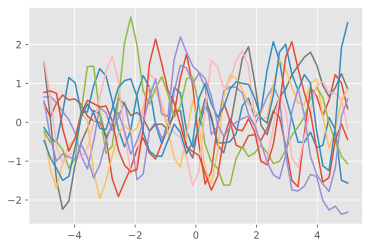

In [8]:
plt.plot(x_test, f_prior)
plt.show()

Indeed, the sampled data seems to present somewhat smooth curves, although the smoothness is somewhat mitigated by the fact that the model are only vectors of 50 dimensions. However, we would expect them to look even smoother had we augmented the dimensions of the test data to 100 dimensions or more.

Next, we need a function from which we generate dummy train data. For the purposes of demonstration, let's choose a simple sine function.

In [4]:
f = lambda x: np.sin(0.9 * x)

Let's generate 15 training data points from this function. Note that we are performing a noiseless GP regression, since we did not add any Gaussian noise to `f`. However, we already know how to perform GP with noise, as we discussed eariler how noise only affects the diagonal entries of the kernel. 

In [9]:
n_train = 15
x_train = np.random.uniform(-5, 5, n_train)
y_train = f(x_train)

Now it's time to model the posterior. Recall that the posterior distribution can be expressed as

$$
\hat{y} \vert D = \mathcal{N}(K_*^\top K^{-1} y, K_{**} - K_*^\top K^{-1} K_*) \tag{20}
$$

If we use `np.linalg.inverse()` or `np.linalg.pinverse()` functions to calculate the inverse of the kernel matrix components, out life would admittedly be easy. However, using inversion is not only typically costly, but also prone to inaccuracy. Therefore, we instead opt for a safer method, namely usisng `np.linalg.solve()`. In doing so, we wil also be introducing some intermediate variables for clarity.

Let's begin with the expression for the posterior mean $\mu$, which is $K_*^\top K^{-1} y$. The underlying idea is that we can apply Cholesky decomposition on $K$, and use that as a way to circumvent the need for direct inversion. Let $K = L L^\top$, then

$$
\alpha = K^{-1} y = L^{- \top} L^{-1} y \tag{22}
$$

Let's make another substitution, $m = L^{-1} y$. Then,

$$
Lm = y \\
\alpha = L^{- \top} m \implies L^\top \alpha = m \tag{23}
$$

This means that we can calculate the mean $\mu$ as 

$$
\mu = K_{*}^\top L^{- \top} m \tag{24}
$$

Similarly, for the covariance $\Sigma$, we can introduce an intermediate variable $\beta$ from which we obtain

$$
\beta = K^{-1} K_{*} \\
K \beta = K_{*} \\
\therefore \Sigma = K_{**} - K_*^\top \beta \tag{25}
$$

Notice that the final expressions for mean and covariance do not require any form of inversion, which was our end goal for efficient and accurate computation.

Let's transcribe everything back to code.

In [11]:
K = kernel(x_train, x_train)
L = np.linalg.cholesky(K)
m = np.linalg.solve(L, y_train)
alpha = np.linalg.solve(L.T, m)

Let `K_s` refer to $K_*$ (and by the same token `K_ss` refers to $K_{**}$). Then,

In [12]:
K_s = kernel(x_train, x_test)
mu = K_s.T @ alpha

Just to be safe, let's check that `mu` is of the desired shape, namely a vector with 50 entries.

In [13]:
mu.shape

(50,)

Continuing with our computation of the posterior covariance,

In [14]:
beta = np.linalg.solve(K, K_s)
cov = K_ss - K_s.T @ beta

As expected, `cov` is a 50-by-50 matrix.

In [15]:
cov.shape

(50, 50)

We are now almost done. Since we have computed the mean `mu` and covariance `cov`, all there is left is to generate samples from this distribution. For that, we resort to Cholesky decomposition again, recalling the idea discussed earlier in (19). Let's sample a total of 50 samples.

In [16]:
L_cov = np.linalg.cholesky(cov)
n_posterior_sample = 50
f_posterior = mu.reshape(-1, 1) + L_cov @ np.random.normal(size=(n_dim, n_posterior_sample))

`f_posterior` now contains 50 samples generated from the posterior. It's important to keep in mind that these samples are each 50-dimensional vectors---in a sense, they can be considered as "functions", which is why the Gaussian process is often referred to as sampling functions from a multivariate Gaussian. 

Let's plot the final result, alongside the actual function `f`. In red, I've also plotted the average of all the 50 samples to see how accurate the result holds up.

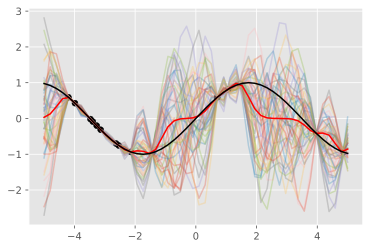

In [18]:
plt.plot(x_test, f_posterior, alpha=0.3)
plt.scatter(x_train, y_train, color="black")
plt.plot(x_test, mu, color="r")
plt.plot(x_test, f(x_test), color="black")
plt.show()

The model behaves exactly as we would expect: where there is data, we are confident; where there is no data, we are uncertain. Therefore, we see little variation on test points near the data. In sparse regions where there is no training data, the model reflects our uncertainty, which is why we observe variation within the sampled functions. Comparing the region $[-4, 2]$ where there is a lot of training data, and $[-1, 0]$ where there is little data, this point becomes apparent. Overall, the average of the fifty samples seems to somewhat capture the overall sinusodial trend present in the training data, notwithstanding the extraneous curvature observed in some regions.

# Conclusion

My first attempt at understanding Gaussian processes probably dates back to earlier this year, when I obtained an electronic copy of Rasmussen's Gaussian Process for Machine Learning. I gave up on chapter 1. The book is still far beyond my current level of mathematics, but nonetheless I am glad that I was able to gain at least a cursory understanding of GP regression. 

I hope you've enjoyed reading this post. In a future post, I hope to dive into another topic I've not been able to understand back then: Gaussian mixture models. See you in the next one!